# Implementation
Author: Jørgen S. Dokken

In this tutorial, you will learn how to:
- Use a vector function space
- Create a constant boundary condition on a vector space
- Visualize cell wise constant functions
- Compute Von Mises stresses

## Test problem
As a test example, we will model a clamped beam deformed under its own weigth in 3D. This can be modeled, by setting the right-hand side body force per unit volume to $f=(0,0,-\rho g)$ with $\rho$ the density of the beam and $g$ the acceleration of gravity. The beam is box-shaped with length $L$ and has a square cross section of width $W$. We set $u=u_D=(0,0,0)$ at the clamped end, x=0. The rest of the boundary is traction free, that is, we set $T=0$. We start by defining the physical variables used in the program.

In [ ]:
# Scaled variable
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl

import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages


We then create the mesh, which will consist of hexahedral elements, along with the function space.
As we want a vector element with three compoenets, we add `(3, )` or `(domain.geometry.dim, )` to the element tuple to make it a triplet
However, we also could have used `basix.ufl`s functionality, creating a vector element `element = basix.ufl.element("Lagrange", domain.topology.cell_name(), 1, shape=(domain.geometry.dim,))`, and intitializing the function space as `V = dolfinx.fem.functionspace(domain, element)`.

## Variational formulation
We are now ready to create our variational formulation in close to mathematical syntax, as for the previous problems.

In [ ]:
domain, _, facet_tags = io.gmshio.read_from_msh("tensile_test_specimen.msh", MPI.COMM_WORLD, 0)
def FEM_Solution(domain, facet_tags, G, K) :
    # Import Geometry
    fdim = domain.topology.dim - 1
    domain.topology.create_connectivity(fdim, domain.topology.dim)

    # Define functionspace
    V = fem.functionspace(domain, ("Lagrange", 1, (3,)))

    # Define Dirichlet Boundary Condition (Dirichelet BC is defined at the facet 3)
    b_D = fem.locate_dofs_topological(V, fdim, facet_tags.find(3))
    u_D = np.array([0, 0, 0], dtype=default_scalar_type)
    bc_D = fem.dirichletbc(u_D, b_D, V)

    # Define Neumann Boundary Condition
    T_neuman = fem.Constant(domain, default_scalar_type((106.26e6, 0, 0 )))
    ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

    # Define Weak form
    def epsilon(u):
        return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
    
    def sigma(u):
        return  (-2/3 * G + K) * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * G * epsilon(u)
    
    # Define Trial and Test Function
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Include Load into the system (the facet for Neumann Boundary is set at facet 4)
    f = fem.Constant(domain, default_scalar_type((0, 0, 0)))
    a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
    L = ufl.dot(f, v) * ufl.dx + ufl.dot(T_neuman, v) * ds(4)

    # Create Solver (Linear)
    problem = LinearProblem(a, L, bcs=[bc_D], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

    # Solve
    uh = problem.solve()
    
    # Post Processing (Retrieve solution in the dataset's domain)
    x_origin_sub = [20e-3, 100e-3]
    y_origin_sub = 10e-3

    domain_arr = domain.geometry.x
    subdomain_condition = (domain_arr[:, 0] >= x_origin_sub[0]) & (domain_arr[:, 0] <= x_origin_sub[1]) # Extract x-coordinates and apply condition
    
    num_dofs = V.dofmap.index_map.size_local
    uh_arr = uh.x.array[:].reshape((num_dofs, -1))

    # Get the subdomain for using with the data
    domain_sub = domain_arr[subdomain_condition]
    domain_sub[:, 0] -= x_origin_sub[0]
    domain_sub[:, 1] += y_origin_sub
    u_sub = uh_arr[subdomain_condition]

    return domain, uh, domain_sub, u_sub

Info    : Reading 'tensile_test_specimen.msh'...
Info    : 28 entities
Info    : 9753 nodes
Info    : 19100 elements
Info    : Done reading 'tensile_test_specimen.msh'


In [6]:
domain, u, domain_sub, u_sub = FEM_Solution(domain, facet_tags, 82e9, 120e9)
node_coordinates = domain_sub
with io.XDMFFile(domain.comm, "deformation_dogbone.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    u.name = "Deformation"
    xdmf.write_function(u)

6.193448879410702e-05


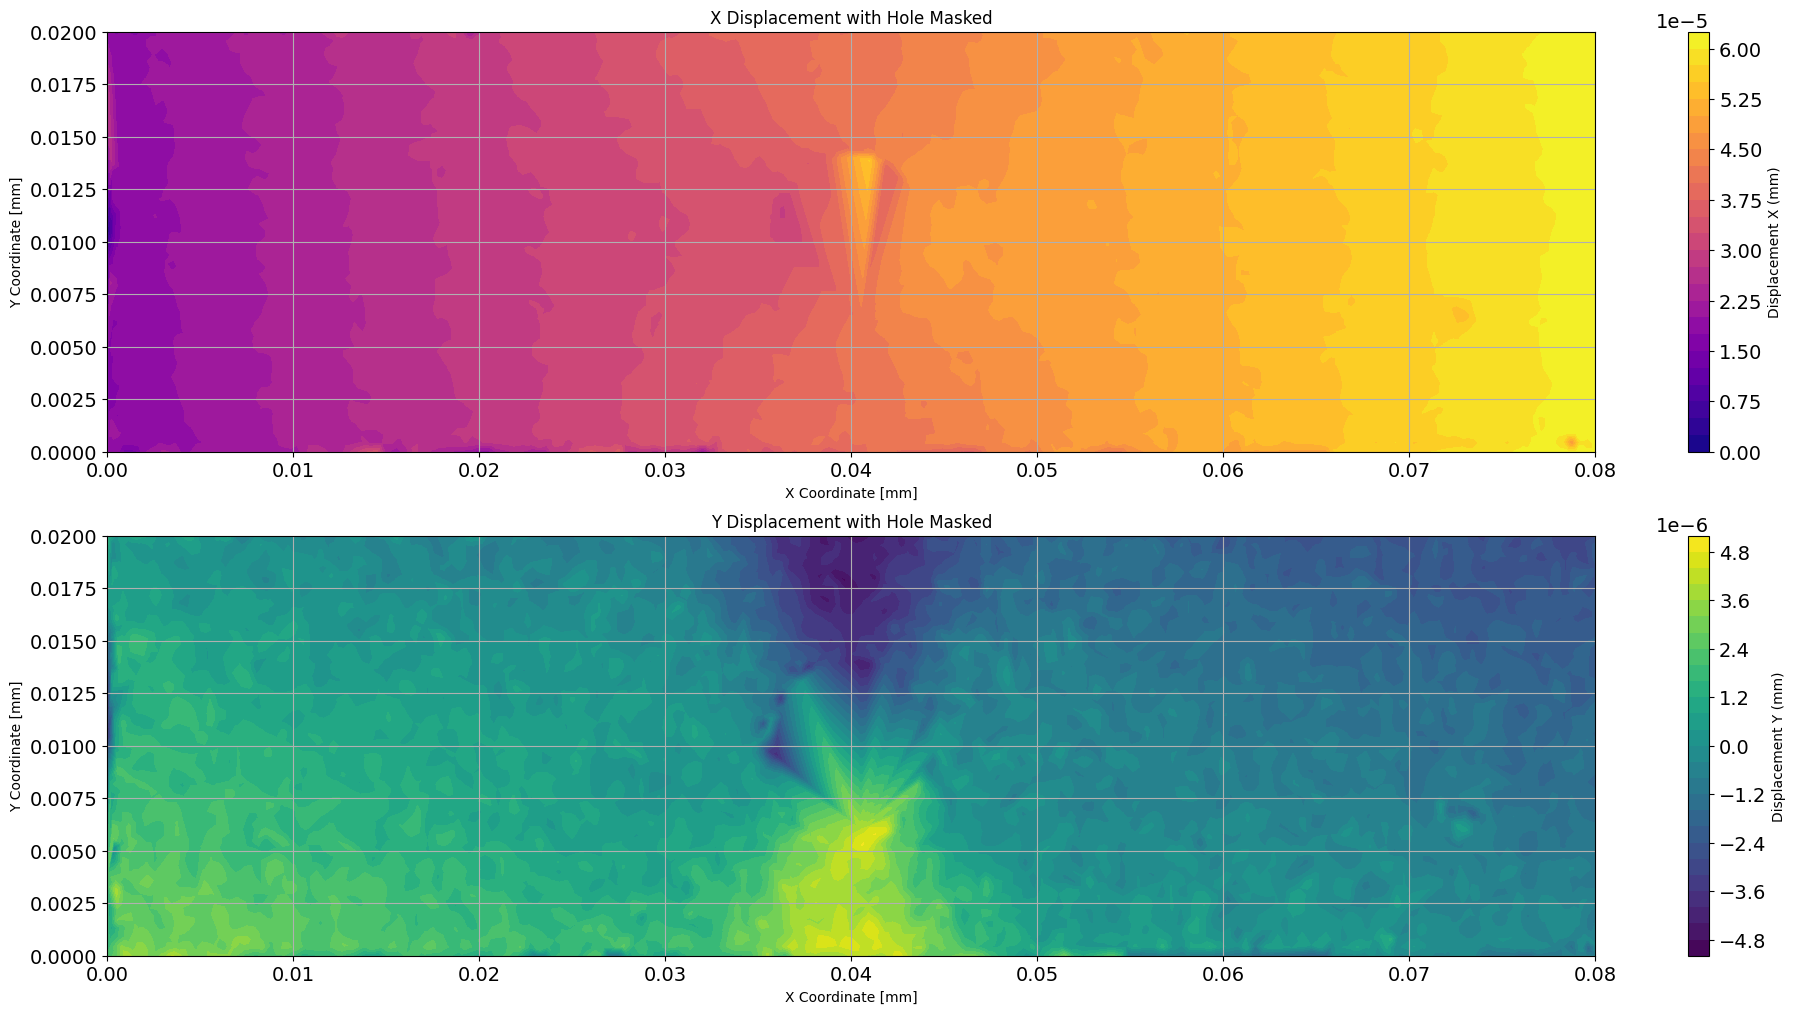

In [91]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator, griddata, NearestNDInterpolator
raw = True
if raw:
    df = pd.read_csv(r"/mnt/c/Users/bankp/OneDrive/Desktop/ADDMM/dataset/20231116_displacements_raw.csv")
else :
    df = pd.read_csv(r"/mnt/c/Users/bankp/OneDrive/Desktop/ADDMM/dataset/20231116_displacements_interpolated.csv")
def remove_outliers_zscore(df, columns, threshold=3):
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.

    Parameters:
    - df: DataFrame from which to remove outliers.
    - columns: List of column names to check for outliers.
    - threshold: Z-score threshold to determine outliers (default is 3).

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    cleaned_df = df.copy()

    for column in columns:
        # Calculate the mean and standard deviation
        mean = cleaned_df[column].mean()
        std = cleaned_df[column].std()

        # Calculate the Z-score for each value in the column
        z_scores = (cleaned_df[column] - mean) / std

        # Filter out outliers based on the Z-score threshold
        cleaned_df = cleaned_df[(np.abs(z_scores) <= threshold)]

    return cleaned_df
def fill_na_with_neighbors(flattened_image, shape):
    rows, cols = shape
    for i in range(1, len(flattened_image) - 1):
        if np.isnan(flattened_image[i]):
            # Get the row and column indices of the pixel in the 2D image
            row = i // cols
            col = i % cols

            # Get the neighbors (left, right, top, bottom) in the flattened array
            neighbors = []
            if col > 0:  # Left neighbor
                neighbors.append(flattened_image[i - 1])
            if col < cols - 1:  # Right neighbor
                neighbors.append(flattened_image[i + 1])
            if row > 0:  # Top neighbor
                neighbors.append(flattened_image[i - cols])
            if row < rows - 1:  # Bottom neighbor
                neighbors.append(flattened_image[i + cols])

            # Remove NaN values from the neighbors list
            neighbors = [val for val in neighbors if not np.isnan(val)]

            # If there are valid neighbors, replace the NaN with the mean
            if neighbors:
                flattened_image[i] = np.mean(neighbors)
    
    return flattened_image

def mask_hole(X, Y) :
    center_x, center_y = 40e-3, 10e-3
    radius = 4e-3

    # Calculate the distance of each point from the center of the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Create a mask: True for points outside the circle, False for points inside
    return distance_from_center >= radius
def get_displacement_at_point(df, x, y, isClearOutlier):
    """
    Interpolates displacement data at a specified (x, y) point.

    Parameters:
    - df: DataFrame with columns ['x', 'y', 'displacement_x', 'displacement_y'].
    - x: float, x-coordinate of the point to interpolate.
    - y: float, y-coordinate of the point to interpolate.
    - method: Interpolation method (default is 'linear').

    Returns:
    - interpolated_displacement_x: Interpolated displacement_x value at the specified point.
    - interpolated_displacement_y: Interpolated displacement_y value at the specified point.
    """
    if isClearOutlier :
        df = remove_outliers_zscore(df, ['x-displacement [mm]', "y-displacement [mm]"], 3)
    # Extract points and displacement values from the DataFrame
    points = df[['x-coordinate [mm]', 'y-coordinate [mm]']].values/1000
    displacement_x = df['x-displacement [mm]'].values/1000
    displacement_y = df['y-displacement [mm]'].values/1000
    # Create interpolators for displacement_x and displacement_y
    # interp_x = np.nan_to_num(griddata(points, displacement_x, (x, y), method='linear'), nan = 0)
    # interp_y = np.nan_to_num(griddata(points, displacement_y, (x, y), method='linear'), nan = 0)
    interp_x = fill_na_with_neighbors(griddata(points, displacement_x, (x, y), method='linear'), points.shape)
    interp_y = fill_na_with_neighbors(griddata(points, displacement_y, (x, y), method='linear'), points.shape)
    return interp_x, interp_y
X, Y = node_coordinates[:, 0], node_coordinates[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
X_train, Y_train =  np.where(mask, X, np.nan), np.where(mask, Y, np.nan)
Z_x_train = np.where(mask, Z_x, np.nan)
Z_y_train = np.where(mask, Z_y, np.nan)
# # Plotting the mesh
fig, ax = plt.subplots(2, 1, figsize=(24, 12))
print(np.max(Z_x))
# # # Subplot for displacement_x
contour_x = ax[0].tricontourf(X, Y , Z_x , levels=25, cmap='plasma')
cbar_x = fig.colorbar(contour_x, ax=ax[0], label='Displacement X (mm)')
ax[0].set_title('X Displacement with Hole Masked')
ax[0].set_xlabel('X Coordinate [mm]')
ax[0].set_ylabel('Y Coordinate [mm]')
ax[0].grid(True)

# Subplot for Y displacement
contour_y = ax[1].tricontourf(X, Y , Z_y, levels=25, cmap='viridis')
cbar_y = fig.colorbar(contour_y, ax=ax[1], label='Displacement Y (mm)')
ax[1].set_title('Y Displacement with Hole Masked')
ax[1].set_xlabel('X Coordinate [mm]')
ax[1].set_ylabel('Y Coordinate [mm]')
ax[1].grid(True)
# Display the plots
plt.show()

In [98]:
from scipy.optimize import minimize, approx_fprime
from scipy.optimize._numdiff import approx_derivative
def callback(xk):
    print(f"Current solution: {xk}")
def gradient_mse_loss(train_ds, BETA):
    """
    Numerical gradient of the MSE Loss function using `approx_fprime`.
    """
    epsilon = np.sqrt(np.finfo(float).eps)  # Step size for numerical differentiation
    return approx_fprime(BETA, lambda x: mse_loss(train_ds, x), epsilon)
class OptimizationHistory:
    def __init__(self):
        self.history = []

    def __call__(self, xk):
        # Save current parameter values
        self.history.append(xk.copy())
def mse_loss(domain, facet_tags, train_ds, BETA) :
    G, K = BETA
    _,_,subdomain,subsol = FEM_Solution(domain, facet_tags, G, K)
    radius = 4e-3 
    center_x, center_y = 40e-3, 10e-3
    distance_from_center = np.sqrt((subdomain[:, 0] - center_x)**2 + (subdomain[:, 1] - center_y)**2)
    distance_from_center_train = np.sqrt((train_ds[:, 0] - center_x)**2 + (train_ds[:, 1] - center_y)**2)
    train_disp_x = train_ds[:, 2][distance_from_center_train >= radius]
    train_disp_y = train_ds[:, 3][distance_from_center_train >= radius]
    fem_disp_x = subsol[:, 0][distance_from_center >= radius]
    fem_disp_y = subsol[:, 1][distance_from_center >= radius]
    # train_disp_x = train_ds[:, 2]
    # train_disp_y = train_ds[:, 3]
    # fem_disp_x = subsol[:, 0]
    # fem_disp_y = subsol[:, 1]
    mean_disp_x = np.mean(np.absolute(train_disp_x))
    mean_disp_y = np.mean(np.absolute(train_disp_y))
    Wx = 1/mean_disp_x
    Wy = 1/mean_disp_y
    err_norm_ux = np.linalg.norm(Wx * (train_disp_x - fem_disp_x))
    err_norm_uy = np.linalg.norm(Wy * 10 * (train_disp_y - fem_disp_y))
    result = (err_norm_ux**2 + err_norm_uy**2) * 0.5
    print(err_norm_ux, err_norm_uy) 
    print(BETA, result) 
    return result
def constraint(BETA):
    G, K = BETA
    return K - (2 / 3) * G      # This value must be > 0
history = OptimizationHistory()
# Define constraint as a dictionary
constraints = {'type': 'ineq', 'fun': constraint}
train_ds = np.hstack((X.reshape(X.shape[0], 1), Y.reshape(Y.shape[0], 1), Z_x.reshape(Z_x.shape[0], 1), Z_y.reshape(Z_y.shape[0], 1)))
beta = [1e+9, 1e+9]
# mse_loss(train_ds, beta)
result = minimize(
    fun=lambda x: mse_loss(domain, facet_tags, train_ds, x),
    x0=beta,
    method='L-BFGS-B',
    options={'gtol': 1e-9, 'maxiter': 1000},
    callback=history
)

6784.984640775644 55126.34159452036
[1.e+09 1.e+09] 1542474777.0856535
6784.984572224514 55126.34036691377
[1.00000001e+09 1.00000000e+09] 1542474708.9470756
6784.9846068695115 55126.341988404216
[1.00000000e+09 1.00000001e+09] 1542474798.5689769
6784.984637072328 55126.34150802195
[1.e+09 1.e+09] 1542474772.2921858
6784.984568520703 55126.34028044503
[1.00000002e+09 1.00000000e+09] 1542474704.1552403
6784.98460316834 55126.341901908556
[1.00000000e+09 1.00000001e+09] 1542474793.775675
6784.98462226189 55126.341162050885
[1.00000000e+09 9.99999998e+08] 1542474753.1195781
6784.9845537077235 55126.33993436403
[1.00000002e+09 9.99999998e+08] 1542474684.9765553
6784.984588353096 55126.341555800835
[1.00000000e+09 1.00000001e+09] 1542474774.5955017
6784.984563007385 55126.33977773133
[1.00000002e+09 9.99999994e+08] 1542474676.405066
6784.984494455364 55126.33855017543
[1.00000003e+09 9.99999994e+08] 1542474608.2692788
6784.984529100087 55126.3401715611
[1.00000002e+09 1.00000001e+09] 154247

In [99]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 235734.4399029782
        x: [ 7.483e+10  9.741e+10]
      nit: 36
      jac: [ 1.112e-08 -2.906e-09]
     nfev: 210
     njev: 70
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [71]:
history_df = pd.DataFrame(history.history, columns=['G', 'K'])
history_df['objective'] = [mse_loss(domain, facet_tags, train_ds, x) for x in history.history]
history_df

[1.08947276e+09 1.00101234e+09] 32296722.081540942
[1.35420307e+09 1.05556878e+09] 21484039.881854728
[1.62366662e+09 1.18687749e+09] 15179894.402803373
[1.99880400e+09 1.43988681e+09] 9980148.146892577
[2.42968557e+09 1.75221069e+09] 6677412.866942998
[2.96267685e+09 2.14052435e+09] 4426721.93973566
[3.60605763e+09 2.61152707e+09] 2936095.7275451543
[4.38873266e+09 3.18704994e+09] 1940291.217202914
[5.33660106e+09 3.88869097e+09] 1278398.3178445655
[6.48361085e+09 4.74475318e+09] 838863.862961743
[7.86766446e+09 5.78668448e+09] 547978.8080381564
[9.53747800e+09 7.06045064e+09] 355571.01842635166
[1.15371905e+10 8.61764380e+09] 229229.19928481814
[1.39225454e+10 1.05034576e+10] 146742.69832789217
[1.67660570e+10 1.28221704e+10] 92861.73860020205
[2.01124157e+10 1.56195824e+10] 58268.21742536778
[2.40096266e+10 1.90438183e+10] 36189.68107577249
[2.85341366e+10 2.31401455e+10] 22280.93388058723
[3.36875082e+10 2.81458188e+10] 13653.466485380608
[3.93443300e+10 3.40446668e+10] 8524.468937

,G,K,objective
0,1.089473e+09,1.001012e+09,3.229672e+07
1,1.354203e+09,1.055569e+09,2.148404e+07
2,1.623667e+09,1.186877e+09,1.517989e+07
3,1.998804e+09,1.439887e+09,9.980148e+06
4,2.429686e+09,1.752211e+09,6.677413e+06
5,2.962677e+09,2.140524e+09,4.426722e+06
6,3.606058e+09,2.611527e+09,2.936096e+06
7,4.388733e+09,3.187050e+09,1.940291e+06
8,5.336601e+09,3.888691e+09,1.278398e+06
9,6.483611e+09,4.744753e+09,8.388639e+05


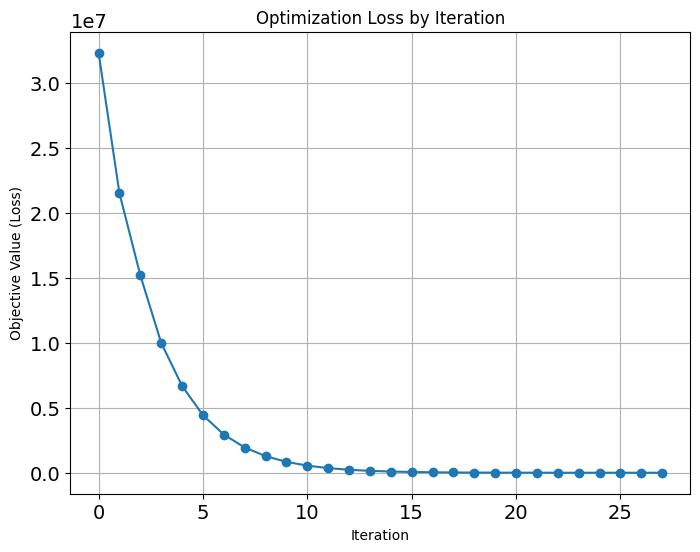

In [100]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(history_df)), history_df["objective"], marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization Loss by Iteration')
plt.grid(True)
plt.show()

In [ ]:
#1e9 1e9 gtol = 1e-9 [7.24031743e+10 9.19440913e+10] 2427.558894518167
#2e9 4e11 gtol = 1e-9 [7.19930049e+10 8.97531837e+10] 2427.28957481075
#7e10 10e10 gtol Nelder-Mead [7.21058705e+10 9.05542148e+10] 2427.1272079029595

In [81]:
mse_loss(domain, facet_tags, train_ds, [7.22372501e+10, 9.7e+10])

[72237250100.0, 97000000000.0] 2416.9177886513257


2416.9177886513257

In [101]:
# print(result)
# # [7.24031743e+10 9.19440913e+10] 4801.424904694527
# G_cal, K_cal = result.x
# G_cal, K_cal = 100.14e9, 299.29e9
#paper
G_cal, K_cal = 7.22372501e+10, 9.16894155e+10
G_cal, K_cal = 7.48329044e+10, 9.74086633e+10
domain_cal, deformation_cal, sub_domain, sub_deformation_cal = FEM_Solution(domain, facet_tags, G_cal, K_cal)

In [73]:
from matplotlib.backends.backend_pdf import PdfPages

6.134621200291642e-05
1.0389615739467922e-05


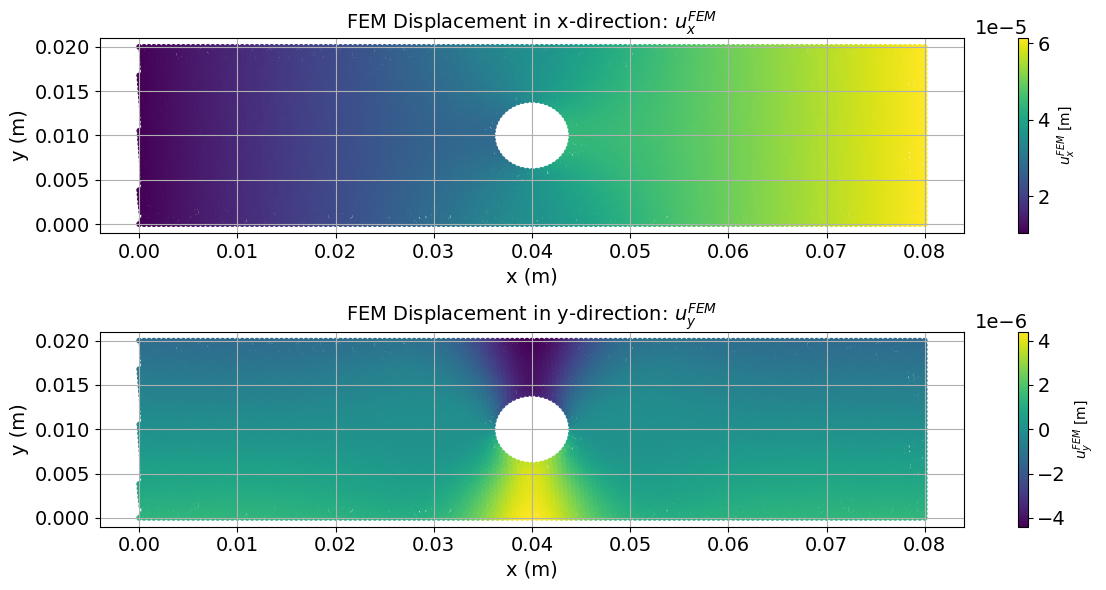

In [102]:
df_solution = pd.DataFrame({"x": sub_domain[:, 0], "y": sub_domain[:, 1], "z_x": sub_deformation_cal[:, 0], "z_y": sub_deformation_cal[:, 1]})
X, Y = sub_domain[:, 0], sub_domain[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
error_field_ux = np.abs(Z_x - sub_deformation_cal[:, 0])
error_field_uy = np.abs(Z_y - sub_deformation_cal[:, 1])
fig, ax = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns
print(max(df_solution["z_x"]))
print(min(df_solution["z_x"]))
# First subplot: Scatter plot for y-displacement
scatter1 = ax[0].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=df_solution["z_x"], cmap='viridis')
fig.colorbar(scatter1, ax=ax[0], label='$u^{FEM}_x$ [m]')
ax[0].set_title('FEM Displacement in x-direction: $u^{FEM}_x$', fontsize=14)
ax[0].set_xlabel('x (m)', fontsize=14)
ax[0].set_ylabel('y (m)', fontsize=14)
ax[0].grid(True)

# Second subplot: Scatter plot for x-displacement
scatter2 = ax[1].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=df_solution["z_y"], cmap='viridis')
fig.colorbar(scatter2, ax=ax[1], label='$u^{FEM}_y$ [m]')
ax[1].set_title('FEM Displacement in y-direction: $u^{FEM}_y$', fontsize=14)
ax[1].set_xlabel('x (m)', fontsize=14)
ax[1].set_ylabel('y (m)', fontsize=14)
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()
pp = PdfPages('disp_field.pdf')
pp.savefig(fig)
pp.close()

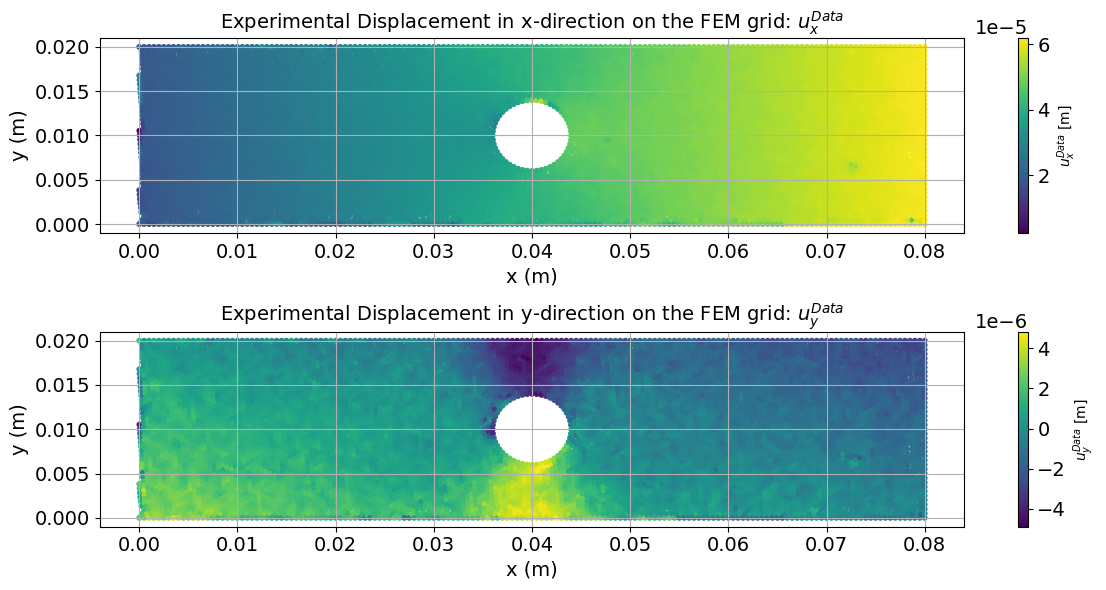

In [103]:
X, Y = sub_domain[:, 0], sub_domain[:, 1]
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
fig, ax = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns
# First subplot: Scatter plot for y-displacement
scatter1 = ax[0].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=Z_x, cmap='viridis')
fig.colorbar(scatter1, ax=ax[0], label='$u^{Data}_x$ [m]')
ax[0].set_title('Experimental Displacement in x-direction on the FEM grid: $u^{Data}_x$', fontsize=14)
ax[0].set_xlabel('x (m)', fontsize=14)
ax[0].set_ylabel('y (m)', fontsize=14)
ax[0].grid(True)

# Second subplot: Scatter plot for x-displacement
scatter2 = ax[1].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=Z_y, cmap='viridis')
fig.colorbar(scatter2, ax=ax[1], label='$u^{Data}_y$ [m]')
ax[1].set_title('Experimental Displacement in y-direction on the FEM grid: $u^{Data}_y$', fontsize=14)
ax[1].set_xlabel('x (m)', fontsize=14)
ax[1].set_ylabel('y (m)', fontsize=14)
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

1.7189117778191043e-05 -1.373133962666942e-05 4.386368728792031e-06
2.98274467404643e-06 -4.15660595917149e-06 -4.9062650634485714e-08


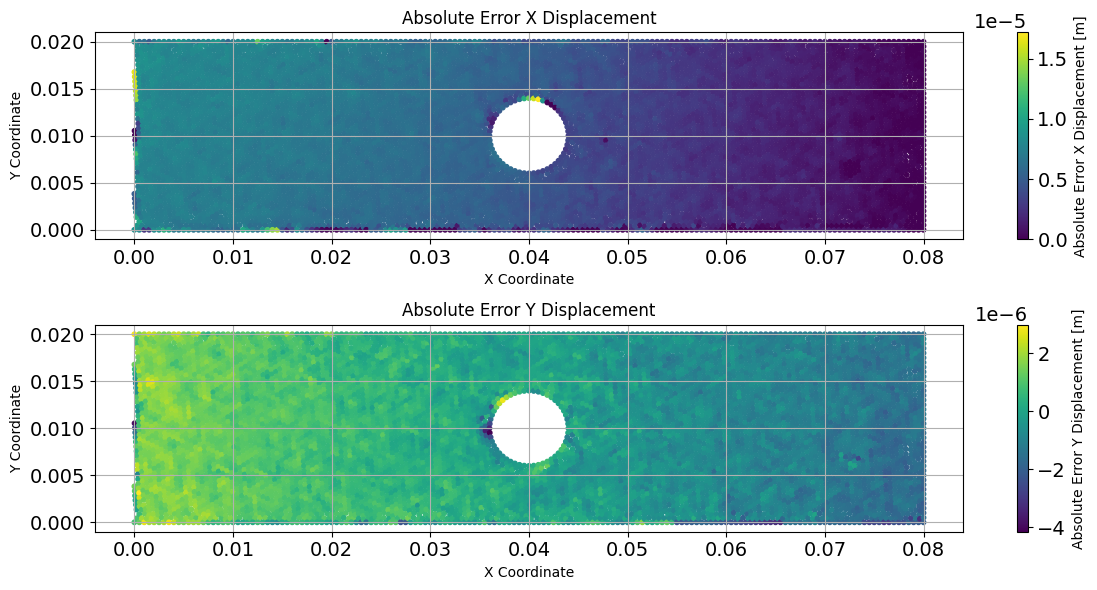

In [ ]:
df_solution = pd.DataFrame({"x": sub_domain[:, 0], "y": sub_domain[:, 1], "z_x": sub_deformation_cal[:, 0], "z_y": sub_deformation_cal[:, 1]})
X, Y = sub_domain[:, 0], sub_domain[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
error_field_ux = Z_x - sub_deformation_cal[:, 0]
error_field_uy = Z_y - sub_deformation_cal[:, 1]
fig, ax = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns
print(max(error_field_ux), min(error_field_ux), np.mean(error_field_ux))
print(max(error_field_uy), min(error_field_uy), np.mean(error_field_uy))

scatter3 = ax[0].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=error_field_ux, cmap='viridis', vmin =0)
fig.colorbar(scatter3, ax=ax[0], label='Absolute Error of Displacement in x-direction $AE_x$[m]')
ax[0].set_title('Absolute Error X Displacement')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
ax[0].grid(True)

scatter4 = ax[1].scatter(df_solution["x"], df_solution["y"], 
                         s=10, c=error_field_uy, cmap='viridis')
fig.colorbar(scatter4, ax=ax[1], label='Absolute Error Displacement in y-direction $AE_y$[m]')
ax[1].set_title('Absolute Error Y Displacement')
ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('y (m)')
ax[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()
pp = PdfPages('error_field.pdf')
pp.savefig(fig)
pp.close()

In [110]:
with io.XDMFFile(domain_cal.comm, "deformation_cal_narunat.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain_cal)
    deformation_cal.name = "Deformation"
    xdmf.write_function(deformation_cal)